# Deep Learning: Traffic Sign Recognition Classifier

This notebook contains the core functionality, which is required to successfully recognize traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) provided by the Institue for Neuroinformatics of the Ruhr-Universität Bochum.

### Importing libraries

In [5]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.utils import shuffle # for shuffling the training data
import cv2 # for grayscaling
from skimage.color import rgb2gray
from skimage import io # read in images from the web
from pandas.io.parsers import read_csv
import math
import scipy.ndimage
import pandas as pd

## Step 0: Load The Data

In [6]:
# load the pickled data based on the location of training, validation and testing data

print('Loading data ...')

training_file = 'data_set/train.p'
validation_file = 'data_set/valid.p'
testing_file = 'data_set/test.p'

# It is good practice to use the "with" keyword when dealing with file objects.
# The advantage is that the file is properly closed after its suite finishes, even if an exception is raised at some point.

with open(training_file, mode='rb') as f: # rb -> r(ead only) and b opens the file in binary mode.
    train = pickle.load(f) # train is a dictionary
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# NumPy arrays
X_train, y_train = train['features'], train['labels'] # 'features' and 'labels' are keys from the dictionary train
# labels (und somit y_train) enthält die GroundTruth-Daten (= die korrekten labels): [41, 41, 41, ... 25, 25, 25]
# mit Länge = Anzahl der Bilder im training set 
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Data successfully loaded.')

Loading data ...
Data successfully loaded.


---

## Step 1: Dataset Summary & Visualization

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height of the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES TAKE ON THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Summary of the original dataset

In [7]:
# Number of training examples
n_train = len(X_train)
print("Number of training samples =", n_train)

# length of ground truth labels
n_train_y = len(y_train)
print("Length of ground truth labels =", n_train_y)

# Number of validation examples
n_validation = len(X_valid)
print("Number of validation samples =", n_validation)

# Number of testing examples.
n_test = len(X_test)
print("Number of testing samples =", n_test)

# Original Shape of one traffic sign image (here: taking the last image in the training set)
image_shape_width = train['sizes'][-1][0]
image_shape_height = train['sizes'][-1][1]
print("Original Shape of the last image in the training set (width x height): ", image_shape_width, "x", image_shape_height)

# Shape of one traffic sign ((here: taking the first image in the training set))
image_shape = X_train[0].shape
print("Shape of the first image in the training set: {}".format(image_shape)) # print out the shape of one image to know what the dimensions of the data are

# Number of unique classes/labels in the training set
n_classes = len(set(train['labels'])) # first make a set out of the dict "train" to remove duplicates, then count the elements in that set
print("Number of classes =", n_classes)

Number of training samples = 34799
Length of ground truth labels = 34799
Number of validation samples = 4410
Number of testing samples = 12630
Original Shape of the last image in the training set (width x height):  230 x 201
Shape of the first image in the training set: (32, 32, 3)
Number of classes = 43


###  Visualization of the original dataset

Visualizing the German Traffic Signs Dataset using the pickled file(s).

It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Let's take a look on the training dataset. We will check each class (type of traffic sign), counting its number of samples and plotting 10 random images. (Notice: Thank you to navoshta for providing this code. Source: https://github.com/navoshta/traffic-signs)

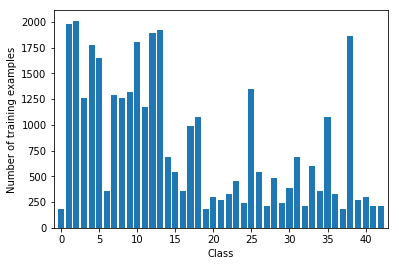

Class 0: Speed limit (20km/h)                                180 samples


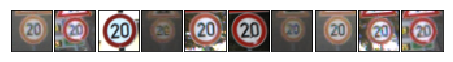

--------------------------------------------------------------------------------------

Class 1: Speed limit (30km/h)                                1980 samples


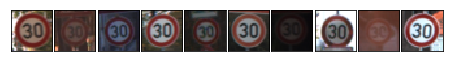

--------------------------------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2010 samples


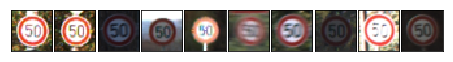

--------------------------------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1260 samples


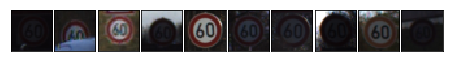

--------------------------------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1770 samples


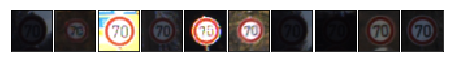

--------------------------------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1650 samples


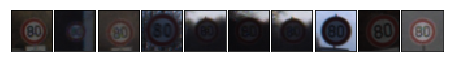

--------------------------------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         360 samples


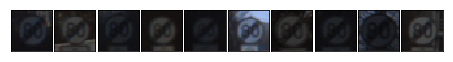

--------------------------------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1290 samples


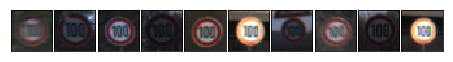

--------------------------------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1260 samples


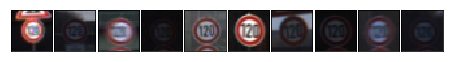

--------------------------------------------------------------------------------------

Class 9: No passing                                          1320 samples


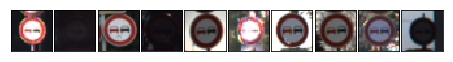

--------------------------------------------------------------------------------------

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


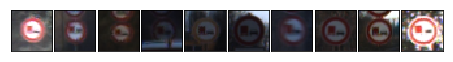

--------------------------------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1170 samples


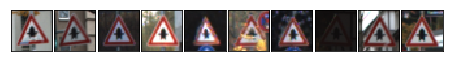

--------------------------------------------------------------------------------------

Class 12: Priority road                                       1890 samples


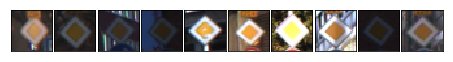

--------------------------------------------------------------------------------------

Class 13: Yield                                               1920 samples


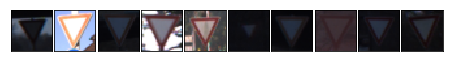

--------------------------------------------------------------------------------------

Class 14: Stop                                                690 samples


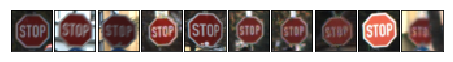

--------------------------------------------------------------------------------------

Class 15: No vehicles                                         540 samples


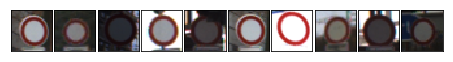

--------------------------------------------------------------------------------------

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


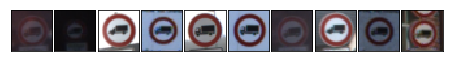

--------------------------------------------------------------------------------------

Class 17: No entry                                            990 samples


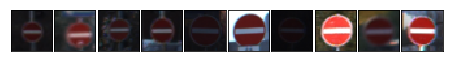

--------------------------------------------------------------------------------------

Class 18: General caution                                     1080 samples


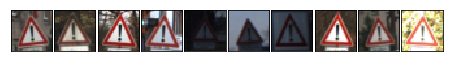

--------------------------------------------------------------------------------------

Class 19: Dangerous curve to the left                         180 samples


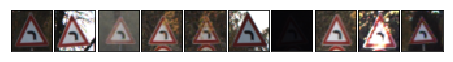

--------------------------------------------------------------------------------------

Class 20: Dangerous curve to the right                        300 samples


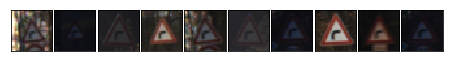

--------------------------------------------------------------------------------------

Class 21: Double curve                                        270 samples


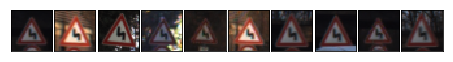

--------------------------------------------------------------------------------------

Class 22: Bumpy road                                          330 samples


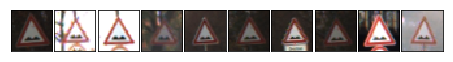

--------------------------------------------------------------------------------------

Class 23: Slippery road                                       450 samples


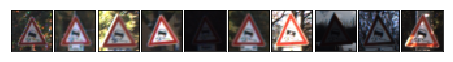

--------------------------------------------------------------------------------------

Class 24: Road narrows on the right                           240 samples


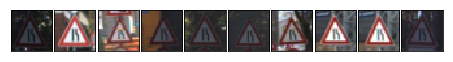

--------------------------------------------------------------------------------------

Class 25: Road work                                           1350 samples


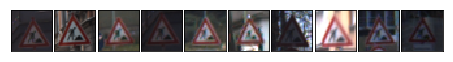

--------------------------------------------------------------------------------------

Class 26: Traffic signals                                     540 samples


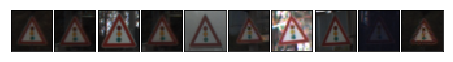

--------------------------------------------------------------------------------------

Class 27: Pedestrians                                         210 samples


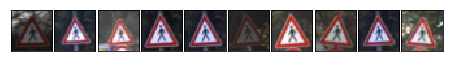

--------------------------------------------------------------------------------------

Class 28: Children crossing                                   480 samples


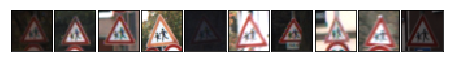

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing                                   240 samples


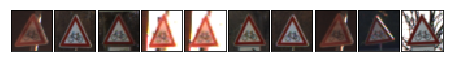

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow                                  390 samples


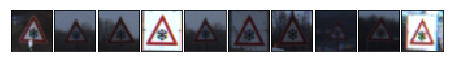

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing                               690 samples


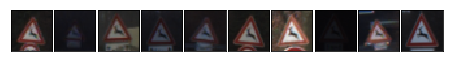

--------------------------------------------------------------------------------------

Class 32: End of all speed and passing limits                 210 samples


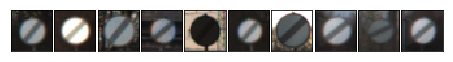

--------------------------------------------------------------------------------------

Class 33: Turn right ahead                                    599 samples


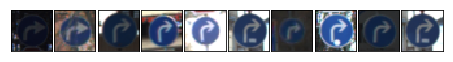

--------------------------------------------------------------------------------------

Class 34: Turn left ahead                                     360 samples


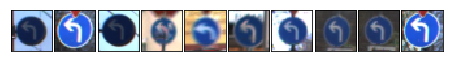

--------------------------------------------------------------------------------------

Class 35: Ahead only                                          1080 samples


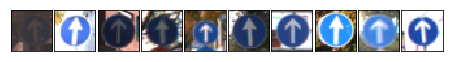

--------------------------------------------------------------------------------------

Class 36: Go straight or right                                330 samples


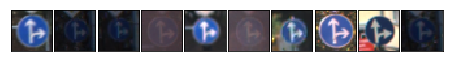

--------------------------------------------------------------------------------------

Class 37: Go straight or left                                 180 samples


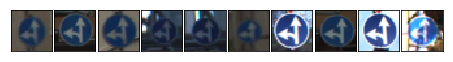

--------------------------------------------------------------------------------------

Class 38: Keep right                                          1860 samples


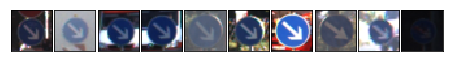

--------------------------------------------------------------------------------------

Class 39: Keep left                                           270 samples


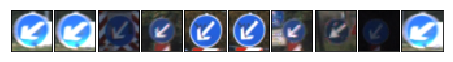

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory                                300 samples


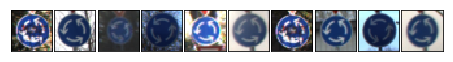

--------------------------------------------------------------------------------------

Class 41: End of no passing                                   210 samples


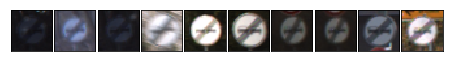

--------------------------------------------------------------------------------------

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


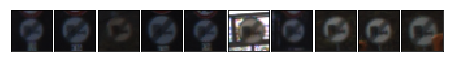

--------------------------------------------------------------------------------------



In [8]:
%matplotlib inline
signnames = read_csv("signnames.csv").values[:, 1] # the second column of csv contains the signnames

sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

col_width = max(len(name) for name in signnames)

# display the distribution of classes in the training set
plt.bar(np.arange(43), class_counts, align='center')
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

# for each class count its number of samples and plot 10 random images
for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

Some classes are highly **underrepresented**. Some have only have 200 samples or even less, which is not enough for most of the models to perform well. It is also fairly unbalanced which means some classes are represented to significantly lower extent than others. This could be fixed with **Data augmentation**.

### Data augmentation

Augmenting the training set helps improving the model. It makes the model more robust to slight variations, and hence prevents the model from overfitting.
Augmenting techniques are "cheap tricks" because no additional data needs to be collected and only a small mount on additional computing resources are needed but performance can significantly be improved.

#### Flipping

Signs like "Ahead Only" are horizontally and/or vertically symmetrical. These can be simply flipped, which would allow us to get twice as much data for these classes.

Other signs like "Turn right ahead" and "Turn left ahead" are some kind of interchageable pairs. These can in a first step be flipped and then be assigned to the corresponding, pairing class. In this case the number of samples could be increased by a factor of around 4.

#### Translation, scaling (zoom) and rotation

CNNs have built-in invariance to small translations, scaling and rotations. The training doesn't contain such mutations, so we will add those. In this project we implement rotation.

In [9]:
## Data augmentation technique: Rotation
degrees = 10

# Rotating images
degrees_positive = 10
X_train_rotated_positive = []
for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_positive)
    X_train_rotated_positive.append(rotated_image)
    
degrees_negative = 350
X_train_rotated_negative = []
for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_negative)
    X_train_rotated_negative.append(rotated_image)    

# Crop image, due to other image size after rotation. Attention: it's not automated! It fit's currently to the 10° rotation.
for i in range(len(X_train_rotated_positive)):
    X_train_rotated_positive[i] = X_train_rotated_positive[i][2:34,2:34]   # box=(y:y+crop, x:x+crop)

for i in range(len(X_train_rotated_negative)):
    X_train_rotated_negative[i] = X_train_rotated_negative[i][2:34,2:34]   # box=(y:y+crop, x:x+crop)
    
# appending rotated images to training set

# Convert the data into list type to use the method "append"
X_train = list(X_train)

# combine the Lists
for i in range(len(X_train_rotated_positive)):
    X_train.append(X_train_rotated_positive[i])
    X_train.append(X_train_rotated_negative[i])
    
#Convert the data back to a np.array
X_train = np.array(X_train)

# New number of training examples (after data augmentation)
new_n_train = len(X_train)
print("New number of training samples after data augmentation =", new_n_train)


# do the same for the labels y_train
# Convert the data into list type to use the method "append"
y_train = list(y_train)

# lengthen the list
for i in range(len(y_train)):
    y_train.append(y_train[i])
    y_train.append(y_train[i])
    
#Convert the data back to a np.array
y_train = np.array(y_train)

# New length of ground truth labels
new_n_train_y = len(y_train)
print("New length of ground truth labels =", new_n_train_y)

New number of training samples after data augmentation = 104397
New length of ground truth labels = 104397


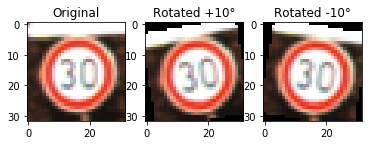

In [10]:
# Display an example for rotation

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(X_train[3000])
ax1.set_title('Original')    
ax1.axis('ON')  # clear x- and y-axes
ax2.imshow(X_train_rotated_positive[3000])
ax2.set_title('Rotated +10°')    
ax2.axis('ON')  # clear x- and y-axes
ax3.imshow(X_train_rotated_negative[3000])
ax3.set_title('Rotated -10°')   
ax3.axis('ON')  # clear x- and y-axes
plt.savefig('./examples/Figure_original_rotated.jpg', dpi=300)
plt.show()

### Data preprocessing

#### Normalizing
Normalizing helps the network to converge faster. It makes it a lot easier for the optimizer to proceed numerically.
It is required to normalize the image data so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. It doesn't change the content of the images.

#### Single-channel images (e.g. grayscale)
I will only use a single channel in my model, e.g. grayscale images instead of color ones. As Pierre Sermanet and Yann LeCun mentioned in [their paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), using color channels didn't seem to improve things a lot.

In [11]:
# Normalize the image data
for i in range(len(X_train)):
    X_train[i] = cv2.normalize(X_train[i],None,0,128,cv2.NORM_MINMAX)
    
for i in range(len(X_valid)):
    X_valid[i] = cv2.normalize(X_valid[i],None,0,128,cv2.NORM_MINMAX)
    
for i in range(len(X_test)):
    X_test[i] = cv2.normalize(X_test[i],None,0,128,cv2.NORM_MINMAX)

# Alternatively
#X_train = (X_train - 128)/128
#X_valid = (X_valid - 128)/128
#X_test = (X_test - 128)/128

In [12]:
# Grayscale
X_train = np.sum(X_train/3, axis = 3, keepdims=True)
X_valid = np.sum(X_valid/3, axis = 3, keepdims=True)
X_test = np.sum(X_test/3, axis = 3, keepdims=True)

image.shape -->  (32, 32)
image.size -->  1024
image.dtype -->  float64


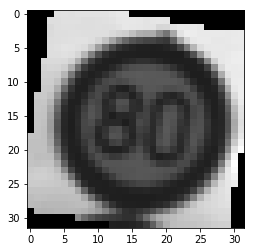

In [13]:
# Show a random image to demonstrate how it changes through preprocessing
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
print('image.shape --> ', image.shape)
print('image.size --> ', image.size)
print('image.dtype --> ', image.dtype)
plt.imshow(image, cmap="gray")

----

## Step 2: Design a Model Architecture (Deep Learning model)

In [14]:
from tensorflow.contrib.layers import flatten

def LeNet(x, mu, sigma, strides, strides_pool, keep_prob):
    
    # Layer 1: Convolutional.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma)) 
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=strides, padding='VALID') + conv1_b # convolve the filter over the images
    print("Shape after 1st convolutional layer: ", conv1.shape)

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Pooling. 
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 1st pooling: ", conv1.shape)
    
    # Layer 3: Convolutional. 
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 64), mean = mu, stddev = sigma)) 
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv1, conv3_W, strides=strides, padding='VALID') + conv3_b # convolve the filter over the images
    print("Shape after 2nd convolutional layer: ", conv3.shape)

    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Layer 4: Pooling. 
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 2nd pooling: ", conv3.shape)

    # Layer 5: Convolutional.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 256), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(256))
    conv5   = tf.nn.conv2d(conv3, conv5_W, strides=strides, padding='VALID') + conv5_b
    print("Shape after 3rd convolutional layer: ", conv5.shape)
    
    # Activation.
    conv5 = tf.nn.relu(conv5)

    # Layer 6: Pooling. 
    conv5 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 3rd pooling: ", conv5.shape)

    # Layer 7: Fully Connected (flatten into a vector).
    fc0 = flatten(conv5)
    print("Shape after flatten: ", fc0.shape)
    
    # Layer 8: Fully Connected. Output = 120 (= width of fully connected layer).
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print("Shape after 1st fully connecting: ", fc1.shape)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    print("Shape after dropout: ", fc1.shape)

    # Output = 43 (because n_classes=43).
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    print("Shape after 2nd fully connecting: ", logits.shape)
    
    return logits

## Step 3: Train and Evaluate the Deep Learning model

### Tuning hyperparameters
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [15]:
EPOCHS = 50 # tells TensorFlow how many times to run our training data through the network
# in general the more epochs, the better our model will train but also the longer training will take.

BATCH_SIZE = 128 # tells TensorFlow how many training images to run through the network at a time
# the larger the batch size, the faster our model will train, but our processor may have a memory limit on how large a batch
# it can run

rate = 0.0005 # tells TensorFlow how quickly to update the network's weights; 0.001 is a good default value but can be experimented with
mu = 0 # used in tf.truncated_normal() --> see the model architecture LeNet() below
sigma = 0.1 # dito

# strides 's'. These are passed into LeNet()
strides = [1, 1, 1, 1] # [batch, y_direction, x_direction, input_channels]
strides_pool = [1, 2, 2, 1] # dito

# Dropout technique
keep_prob = 0.7

### Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels (groundtruth data).

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # initialize batch size to "None" which allows the placeholder to later accept a batch of any size
y = tf.placeholder(tf.int32, (None)) # not yet one-hot encoded

one_hot_y = tf.one_hot(y, 43) # 1-hot encode the labels

### Training pipeline
`training_operation`

In [17]:
# pass the input data x (batch of images) to the LeNet function (deep neural network) to calculate logits
logits = LeNet(x, mu, sigma, strides, strides_pool, keep_prob)

# cross entropy is a measure of how different the logits are from the ground truth training labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) # averages the CE from all of the training images
optimizer = tf.train.AdamOptimizer(learning_rate = rate) # uses Adam algorithm to minimize the loss function similarly to SGD.
                                                         # little bit more sophisticated than SGD
training_operation = optimizer.minimize(loss_operation) # run the minimize function on the optimzier which uses backprop to
# upgrade the network and minimize our training loss

Shape after 1st convolutional layer:  (?, 30, 30, 16)
Shape after 1st pooling:  (?, 15, 15, 16)
Shape after 2nd convolutional layer:  (?, 13, 13, 64)
Shape after 2nd pooling:  (?, 6, 6, 64)
Shape after 3rd convolutional layer:  (?, 4, 4, 256)
Shape after 3rd pooling:  (?, 2, 2, 256)
Shape after flatten:  (?, 1024)
Shape after 1st fully connecting:  (?, 120)
Shape after dropout:  (?, 120)
Shape after 2nd fully connecting:  (?, 43)


### Evaluation pipeline
`accuracy_operation`

Evaluate the accuracy of the model.

In [18]:
# Compare the logit prediction to the 1-hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

# Calculate the model's overall accuracy by averaging the individual prediction accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] # batch the dataset
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y}) # run the batched dataset through the evaluation pipeline
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and Validate the model

Run the training data through the training pipeline to train the model -->`training_operation`

Before each epoch, training set will be shuffled to ensure that training is not biased by the order of the images.

After each epoch, the validation accuracy and accuracy on the training set are measured. A low accuracy on the training and validation sets implies underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The model will be saved after training.

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE): # range(start, stop, step)
            end = offset + BATCH_SIZE
            batch_x = X_train[offset:end] # break training data into batches
            batch_y = y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y}) # train the model on each batch
            
        # at the end of each epoch, we evaluate the model on our validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        
        # also evaluate the model on training data to see if the model is over- or underfitted
        training_accuracy = evaluate(X_train, y_train)
        
        # also evaluate the model on test data (different from validation data)
        test_accuracy = evaluate(X_test, y_test)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Accuracy on the training set = {:.3f}".format(training_accuracy))
        print("Accuracy on the test set = {:.3f}".format(test_accuracy))
        
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    
    saver.save(sess, 'lenet') # save the model to be able to load it up later and modify it or evaluate it on test dataset
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.481
Accuracy on the training set = 0.526
Accuracy on the test set = 0.494

EPOCH 2 ...
Validation Accuracy = 0.736
Accuracy on the training set = 0.783
Accuracy on the test set = 0.735

EPOCH 3 ...
Validation Accuracy = 0.829
Accuracy on the training set = 0.885
Accuracy on the test set = 0.820

EPOCH 4 ...
Validation Accuracy = 0.871
Accuracy on the training set = 0.926
Accuracy on the test set = 0.860

EPOCH 5 ...
Validation Accuracy = 0.909
Accuracy on the training set = 0.957
Accuracy on the test set = 0.895

EPOCH 6 ...
Validation Accuracy = 0.921
Accuracy on the training set = 0.968
Accuracy on the test set = 0.906

EPOCH 7 ...
Validation Accuracy = 0.924
Accuracy on the training set = 0.976
Accuracy on the test set = 0.914

EPOCH 8 ...
Validation Accuracy = 0.944
Accuracy on the training set = 0.982
Accuracy on the test set = 0.920

EPOCH 9 ...
Validation Accuracy = 0.943
Accuracy on the training set = 0.984
Accuracy on the test s

---

## Step 3: Use the model to make predictions on new images found on the web

To give more insight into how the model is performing, five pictures of German traffic signs from the web are taken and applied to the model to predict the traffic sign type.

### Load and Output the Images

In [37]:
import os
import glob

# Load images from .png files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.float64) # numpy.empty(shape, dtype); shape > int or tuple of int; 
                                                        # 0 gibt damit die Länge an

In [38]:
# loading the images into a file list (no numpy array! only a list)
additional_file_list = [f for f in glob.glob("examples/web/"+'*.png')]

In [39]:
# Bilder einlesesn und X_custom aufbauen

for i in range(len(additional_file_list)):
    image = io.imread(os.getcwd() + '/examples/web/' + "example_{0:0>5}".format(i + 1) + '.png')
    print("read in image has shape: ", image.shape) # DEBUG; why is an image imported with 4 channels?
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0) # X_custom wird kopiert und [image[:, :, :3]] drangehängt
        
print("len(X_custom): ", len(X_custom))
print("X_custom.shape: ", X_custom.shape)
print("X_custom.dtype: ", X_custom.dtype)

read in image has shape:  (32, 32, 3)
read in image has shape:  (32, 32, 3)
read in image has shape:  (32, 32, 3)
read in image has shape:  (32, 32, 3)
read in image has shape:  (32, 32, 3)
len(X_custom):  5
X_custom.shape:  (5, 32, 32, 3)
X_custom.dtype:  float64


In [40]:
# Provide labels for the images found on the web:

"""
# eigene Bilder
y_custom = np.array([
    25, # "example_00001"
    23, # "example_00002"
    16, # "example_00003"
    17, # "example_00004"
    39, # "example_00005"
])
"""


# DiegeID
y_custom = np.array([
    14, # "example_00001"
    13, # "example_00002"
    12, # "example_00003"
    7, # "example_00004"
    17, # "example_00005"
])

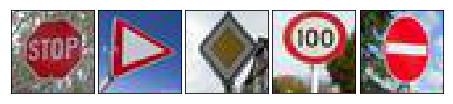

In [41]:
fig = plt.figure()
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for i in range(len(X_custom)):
    axis = fig.add_subplot(1, len(additional_file_list), i + 1, xticks=[], yticks=[])
    web_image = io.imread(os.getcwd() + '/examples/web/' + "example_{0:0>5}".format(i + 1) + '.png')
    axis.imshow(web_image)

In [ ]:
# Alternativ: Plotten mit fester Anzahl von Bildern, z.B. 5

'''
f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20, 32))
ax1.imshow(additional_imag_list[0])
ax1.axis('ON')
ax2.imshow(additional_imag_list[1])
ax2.axis('ON')
ax3.imshow(additional_imag_list[2])
ax3.axis('ON')
ax4.imshow(additional_imag_list[3])
ax4.axis('ON')
ax5.imshow(additional_imag_list[4])
ax5.axis('ON')
#plt.savefig('./examples/name_of_file.jpg', dpi=300)
plt.show()
'''

### Predict the Sign Type for Each Image
Output the prediction for each image using the model

In [42]:
# Preprocessing the images with the same techniques used earlier (normalize and grayscale)

# Normalize
for i in range(len(X_custom)):
    X_custom[i] = cv2.normalize(X_custom[i],None,0,128,cv2.NORM_MINMAX)

In [43]:
# Grayscale
X_custom = np.sum(X_custom/3, axis = 3, keepdims=True)
print("X_custom[0].shape: ", X_custom[0].shape)
print("X_custom.shape: ", X_custom.shape)

X_custom[0].shape:  (32, 32, 1)
X_custom.shape:  (5, 32, 32, 1)


In [ ]:
## Try this to make prediction for a single image

'''
x_1 = tf.cast(X_custom[0], tf.float32) # to resolve "TypeError: Value passed to parameter 'input' has DataType float64 not in list of allowed values: float16, float32"
x_1_expanded = tf.expand_dims(x_1, 0)
y_1 = y_custom[0]
logits = LeNet(x_1_expanded, mu, sigma, strides, strides_pool, keep_prob)
'''

### Analyze Performance

In [29]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [53]:
## short version with calling evaluate(X_custom, y_custom) directly. Only can run when long version (next cell) works!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_custom)
    web_accuracy = evaluate(X_custom, y_custom)
    print("Accuracy on images found on the web = {:.3f}".format(web_accuracy))

Accuracy on images found on the web = 0.200


In [ ]:
## long version (step by step) with batches

"""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_custom) # 5
    total_accuracy = 0
    BATCH_SIZE = 1
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_custom[offset:offset+BATCH_SIZE]
        batch_y = y_custom[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y}) # run the batched dataset through the evaluation pipeline
        total_accuracy += (accuracy * len(batch_x))
        
print(total_accuracy / num_examples)
"""

In [ ]:
## long version (step by step) without batches

"""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_custom) # 5
    total_accuracy = 0
    for i in range(num_examples):
        x_i = X_custom[i:i+1]
        y_i = y_custom[i:i+1]
        accuracy = sess.run(accuracy_operation, feed_dict={x: x_i, y: y_i})
        total_accuracy += (accuracy * len(x_i))
        
print(total_accuracy / num_examples)
"""

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [54]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

top_classes = tf.nn.top_k(tf.nn.softmax(logits), k=5) # tf.nn.top_k(input, k=?)

"""
input: 1-D or higher tensor
k: number of top elements/largest entries to look for along each row
"""

'\ninput: 1-D or higher tensor\nk: number of top elements/largest entries to look for along each row\n'

In [55]:
print(type(top_classes))

<class 'tensorflow.python.ops.gen_nn_ops.TopKV2'>


In [56]:
keep_prob = 1.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    top_classes_output = sess.run(top_classes, feed_dict = {x:X_custom, y:y_custom})
    
    # sess.run(tf.global_variables_initializer())
    # num_examples = len(X_custom)
    # for i in range(num_examples):
       # x_i = X_custom[i:i+1]
       # y_i = y_custom[i:i+1]
       # top_classes_output = sess.run(top_classes, feed_dict = {x:x_i, y:y_i})

In [57]:
print(top_classes_output)

TopKV2(values=array([[  8.50318134e-01,   1.48340896e-01,   1.34043326e-03,
          4.22929332e-07,   9.41116056e-08],
       [  1.00000000e+00,   1.21763138e-14,   1.73997119e-20,
          6.74108144e-26,   2.85920293e-26],
       [  9.98181105e-01,   1.81890302e-03,   1.31884995e-13,
          1.26804993e-13,   2.06013892e-15],
       [  9.81205225e-01,   1.84670482e-02,   3.24184366e-04,
          3.40046677e-06,   8.36744150e-08],
       [  9.99999881e-01,   1.00730510e-07,   5.87874212e-08,
          5.64235941e-12,   4.99046469e-14]], dtype=float32), indices=array([[23, 42, 17, 10, 27],
       [17, 31, 27, 23, 42],
       [23, 17, 27, 28, 42],
       [20,  0,  4, 17, 23],
       [17, 28,  0, 41, 23]], dtype=int32))


In [ ]:
saver.restore(sess, './lenet')
print("Model restored.")

"""
# from: https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

with tf.Session() as sess:
  new_saver = tf.train.import_meta_graph('lenet.meta')
  new_saver.restore(sess, tf.train.latest_checkpoint('./'))

In [ ]:
import pandas

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    print("Model restored.")
    top_classes_out = sess.run(top_classes, feed_dict={x: add_imag_list_resised_converted, y: add_signal_labels})
    
    for i in range(len(top_classes_out[0])):      
        print('\r\n --- Prediction ' +str(i+1) + ' '+'---')
        for j in range(len(top_classes_out[0][i])):
            pre = top_classes_out[0][i][j]
            lab = top_classes_out[1][i][j]
            print ( str(pre) + '  ' + str(signnames.SignName[lab]))

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")